In [1]:
import pandas as pd
from efficientnet_pytorch import EfficientNet
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
torch.cuda.empty_cache()

import glob

from sklearn.metrics.pairwise import cosine_similarity

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
torch.cuda.empty_cache()
import boto3
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
os.environ['AWS_ACCESS_KEY_ID'] = 'AWS_ACCESS_KEY_ID'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'AWS_SECRET_ACCESS_KEY'

s3 = boto3.resource('s3')

def read_image_from_s3(key):
    bucket = s3.Bucket('s3 path')
    img = bucket.Object(key).get().get('Body').read()
    img = cv2.imdecode(np.asarray(bytearray(img)), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [3]:
def read_csv_from_s3(stage):

    if stage == 'public':
        df = pd.read_csv('s3 public.csv path ')
    elif stage == 'private':
        df = pd.read_csv('s3 private_final.csv path')
    elif stage == 'public_private':
        df = pd.read_csv('s3 test.csv path')
    elif stage == 'index':
        df = pd.read_csv('s3 index_final.csv path')
        

    else:
        raise ValueError(f'not supported stage{stage}')
    return df

In [4]:
class SiameseGLDV2(Dataset):

    def __init__(self, stage: str, inferance=True):

        self.df = read_csv_from_s3(stage)
        self.df.drop(self.df.filter(regex="Unname"), axis=1, inplace=True)
        self.label_list = self.df.landmark_id.tolist()
        self.namelist = [i.split('\\')[-1] for i in self.df.anchor.tolist()]
        print(f'shape of df is {len(self.df)}, stage is {stage}')
        self.s3 = boto3.resource('s3')
        if stage == 'index':
            self.s3path = 's3 train path'
        else:
            self.s3path = 's3 test path'
        self.my_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])


    def __getitem__(self, index):
        label = self.df.iloc[index]['landmark_id']
        anchor = self.df.iloc[index]['anchor'].split('\\')
        anchor_class = anchor[1]
        anchor_filen = anchor[2]
        anchor_image = self.s3path + '/' + anchor_class + '/' + anchor_filen
        try:
            anchor_im = read_image_from_s3(anchor_image)
        except:
            anchor_im = []
            print(f'Error by {anchor_image}')
        transformed_anchor_im = self.my_transformer(anchor_im)
        return label, transformed_anchor_im , anchor_im

In [5]:
def map_at_k(y_true, y_denominator, y_pred):
    assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)
    assert y_true.ndim == 2 and y_pred.ndim == 2

    k = y_pred.shape[1]
    is_correct_list = []

    for i in range(y_true.shape[1]):
        is_correct = y_true[:, i][:, np.newaxis] == y_pred
        is_correct_list.append(is_correct)
    is_correct_mat = np.logical_or.reduce(np.array(is_correct_list))

    cumsum_mat = np.apply_along_axis(np.cumsum, axis=1, arr=is_correct_mat)
    arange_mat = np.expand_dims(np.arange(1, k + 1), axis=0)
    ap_100_list = np.sum((cumsum_mat / arange_mat) * is_correct_mat, axis=1) / y_denominator
    ap_100_list[ap_100_list>1]=1

    return np.mean(ap_100_list), ap_100_list

def list_to_array (x):
    dff = pd.concat([pd.DataFrame({'{}'.format(index):labels}) for index,labels in enumerate(string_to_list(x))],axis=1)
    return dff.fillna(0).values.T.astype(int)

def string_to_list(x):
    res = []
    for a in x:
        tmp = a.split(' ')
        tmp2= [int(i) for i in tmp]
        res.append(tmp2)
    return res

In [6]:
BATCH_SIZE = 500
class NN:
    def __init__(self, batch_size=BATCH_SIZE, dim=512):
        self.array = np.empty((0, dim))
        self.id = []
        self.score = np.empty((0, batch_size))

    def add_item(self, item):
        if item.ndim == 1:
            item = item[np.newaxis, :]
        self.array = item

    def search(self, search_item, top_k=100):
        self.res = cosine_similarity(self.array, search_item)
        self.score = np.concatenate((self.score, self.res), axis=0)
        self.rank = self.res[:, 0].argsort()[::-1][:top_k]

    def update(self):
        self.array = np.array([self.array[i] for i in self.rank])
        self.id = [self.id[i] for i in self.rank]

    def get_top_k(self, top_k=100):
        return np.argsort(-self.score, axis=0)[:top_k, :]

def index_to_label(index_array, label_list):
    res = []
    for i in range(len(index_array)):
        res.append(label_list[index_array[i].astype(int)])
    return np.array(res)

def comt_denominater(y_true, index_label_list):
    res = []
    for i in y_true:
        count = 0
        for j in i:
            count += index_label_list.count(j)
        res.append(count)
    res = np.array(res)
    res[res > 50] = 50
    return res

In [7]:
index_dataset = SiameseGLDV2('index')
test_dataset = SiameseGLDV2('public')

shape of df is 100000, stage is index
shape of df is 350, stage is public


In [8]:
npy_list_index = sorted(glob.glob('out/index/*.npy'))
npy_list_test = sorted(glob.glob('out/test/*.npy'))
images = []
score_list = []
ranked_list = []
aps = []

for ind,npy_test_path in tqdm(enumerate(npy_list_test)):
    
    npy_test = np.load(npy_test_path)
    indexer = NN(dim=1000, batch_size=npy_test.shape[0])
    for i,npy_index_path in tqdm(enumerate(npy_list_index)):
        npy_index = np.load(npy_index_path)
        indexer.add_item(npy_index)
        indexes = indexer.search(npy_test)
    top_k_array = indexer.get_top_k()
    ranked_list.append(top_k_array)
    y_true = list_to_array(test_dataset.label_list[ind*BATCH_SIZE:min((ind+1)*BATCH_SIZE, len(test_dataset.label_list))])
    map_100,ap_list = map_at_k(y_true= y_true,
             y_denominator= comt_denominater(y_true, index_dataset.label_list),
             y_pred= index_to_label(top_k_array.T,np.array(index_dataset.label_list)))
    aps.extend(ap_list)
    score_list.extend(list(np.sort(indexer.score, axis=0)[-1,:]))
ranked_list = np.hstack(ranked_list)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
12it [00:00, 117.65it/s]
24it [00:00, 64.95it/s] 
32it [00:00, 47.62it/s]
38it [00:00, 38.94it/s]
43it [00:01, 33.35it/s]
47it [00:01, 29.80it/s]
51it [00:01, 26.53it/s]
54it [00:01, 24.37it/s]
57it [00:01, 22.42it/s]
60it [00:01, 20.74it/s]
63it [00:02, 19.28it/s]
65it [00:02, 18.41it/s]
67it [00:02, 17.49it/s]
69it [00:02, 16.73it/s]
71it [00:02, 16.04it/s]
73it [00:02, 15.33it/s]
75it [00:02, 14.81it/s]
77it [00:03, 14.37it/s]
79it [00:03, 13.75it/s]
81it [00:03, 13.41it/s]
83it [00:03, 13.11it/s]
85it [00:03, 12.75it/s]
87it [00:03, 12.47it/s]
89it [00:04, 12.20it/s]
91it [00:04, 11.90it/s]
93it [00:04, 11.67it/s]
95it [00:04, 11.47it/s]
97it [00:04, 11.19it/s]
99it [00:05, 10.98it/s]
101it [00:05, 10.81it/s]
103it [00:05, 10.58it/s]
105it [00:05, 10.42it/s]
107it [00:05, 10.26it/s]
109it [00:06, 10.04it/s]
111it [00:06,  9.89it/s]
112it [00:06,  9.77it/s]
113it [00:06,  9.69it/s]
114it [00:06,  9.53it/s]
115it [00:06,  9.47it/s]
116it [00:06, 

In [9]:
print('The map@100 is : {}'.format(np.mean(aps)))
print('The max ap@100 is : {}'.format(np.max(aps)))
print('The min ap@100 is : {}'.format(np.min(aps)))
print('The max cos similarity is : {}'.format(max(score_list)))

The map@100 is : 0.1730109796358657
The max ap@100 is : 0.951342383107089
The min ap@100 is : 0.0
The max cos similarity is : 0.9849215149879456


In [10]:
def display_query_and_top_k_match(query_dataset, index_dataset, ranked_list, index, k=24, width=5):
    row = int((k+1)//width)
    k = row * width -1
    images = []
    top_k_indices = ranked_list[:,index]
    top_k_index = top_k_indices[:k]
    label, _, query_img_path = query_dataset[index]
    fig = plt.figure(figsize=(10, row*3.3))
    a = plt.subplot(row, width, 1)
    plt.subplots_adjust(left=0.1, bottom = 0.1, right = 0.95, wspace = 0.1, hspace=0, top = 0.7)
    plt.imshow(query_img_path)
    a.set_title(f'Query image: {label}')
    a.set_xticks([])
    a.set_yticks([])
    
    for i in range(1,k+1):
        label, _, index_img_path = index_dataset[top_k_index[i-1]]
        a = plt.subplot(row, width, i+1)
        plt.imshow(index_img_path)
        a.set_title(f'top{i}:{label}')
        a.set_xticks([])
        a.set_yticks([])
        
    plt.show()

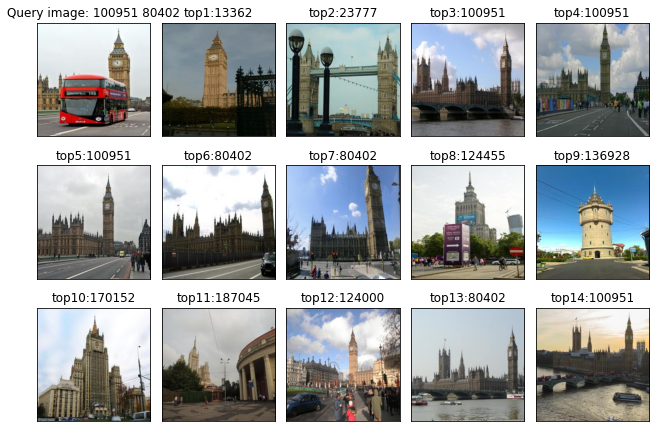

In [11]:
display_query_and_top_k_match(test_dataset, index_dataset, ranked_list, 0, k=14)

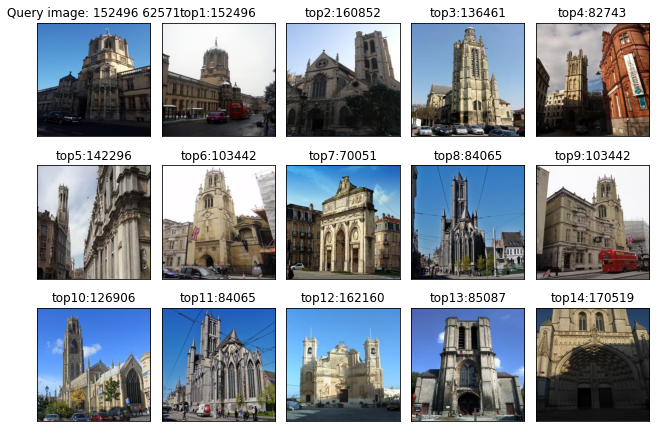

In [12]:
display_query_and_top_k_match(test_dataset, index_dataset, ranked_list, 120, k=14)